# Import Libraries

In [1]:
import pandas as pd

In [2]:
import pickle

In [3]:
import numpy as np

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
import mlflow
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("newest-experiment")

<Experiment: artifact_location='file:///C:/Users/FACULTY OFFICIAL/mlruns/6', creation_time=1697646824622, experiment_id='6', last_update_time=1697646824622, lifecycle_stage='active', name='newest-experiment', tags={}>

# Import dataset

In [11]:
def read_file(file):
    global categorical
    global numerical
    data=pd.read_parquet(file)
    data['trip_duration']=data.lpep_dropoff_datetime-data.lpep_pickup_datetime 
    #print(data.lpep_dropoff_datetime)
    td=data.trip_duration.iloc[0]
    #print(f"Trip duration is: { data['trip_duration']}")
    data.trip_duration=data.trip_duration.apply(lambda td:td.total_seconds()/60 )
    data=data[data.trip_type==2]
    data=data[(data.trip_duration>=1) & (data.trip_duration <=60)]
    #selecting  features
    categorical=['PULocationID', 'DOLocationID']
    numerical=['trip_distance']
    data[categorical].dtypes
    data[categorical]=data[categorical].astype(str)
    return data

In [12]:
#lucky for us the date and time is in 'datetime' format.
#if it wasn't we'd have had to convert ---- pd.to_datetime(data.lpep_dropoof_datetime)

In [13]:
data_train=read_file("C:\\Users\\FACULTY OFFICIAL\\Downloads\\green_tripdata_2021-01.parquet")
data_val=read_file("C:\\Users\\FACULTY OFFICIAL\\Downloads\\green_tripdata_2021-02.parquet")

# Feature Selection

In [14]:
#c1=data.columns.get_loc('PULocationID')
#c2=data.columns.get_loc('DOLocationID')


In [15]:
x=data_train[categorical]
x['trip_distance']=data_train[numerical]

x_val=data_val[categorical]
x_val['trip_distance']=data_val[numerical]


C:\Users\FACULTY OFFICIAL\AppData\Local\Temp\ipykernel_8016\2846468319.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['trip_distance']=data_train[numerical]
C:\Users\FACULTY OFFICIAL\AppData\Local\Temp\ipykernel_8016\2846468319.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_val['trip_distance']=data_val[numerical]


In [16]:
# Assuming 'train_df' and 'val_df' are your training and validation DataFrames
#'PULocationID', 'DOLocationID'
'''train_categ= set(data_train['DOLocationID'].unique())
val_categ = set(data_val['DOLocationID'].unique())

new_categ= val_categ- train_categ
reverse_categ=train_categ-val_categ
for category in new_categ:
    data_train[category] = 0
for category in reverse_categ:
    data_val[category] = 0'''

"train_categ= set(data_train['DOLocationID'].unique())\nval_categ = set(data_val['DOLocationID'].unique())\n\nnew_categ= val_categ- train_categ\nreverse_categ=train_categ-val_categ\nfor category in new_categ:\n    data_train[category] = 0\nfor category in reverse_categ:\n    data_val[category] = 0"

In [17]:
y=data_train['trip_duration']
y_val=data_val['trip_duration']

In [18]:
y

30       19.766667
53       20.733333
69        8.166667
88       12.983333
96        5.316667
           ...    
40324    25.866667
40352    17.900000
40363     9.450000
40364    35.033333
40430    23.150000
Name: trip_duration, Length: 640, dtype: float64

In [19]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression

In [20]:
train_dicts=data_train[categorical + numerical].to_dict(orient='records')
#print(X_train)
dv=DictVectorizer()
X_train=dv.fit_transform(train_dicts)

val_dicts=data_val[categorical + numerical].to_dict(orient='records')
XVal_train=dv.transform(val_dicts)

In [21]:
X_train

<640x236 sparse matrix of type '<class 'numpy.float64'>'
	with 1920 stored elements in Compressed Sparse Row format>

In [22]:
XVal_train

<612x236 sparse matrix of type '<class 'numpy.float64'>'
	with 1754 stored elements in Compressed Sparse Row format>

In [23]:
Regressor=LinearRegression()
Regressor.fit(X_train, y)

LinearRegression()

In [24]:
y_pred=Regressor.predict(X_train)
yval_pred=Regressor.predict(XVal_train)

In [25]:
with open('linear_reg.bin','wb') as fout:
    #open the file in write mode for binary data
    pickle.dump((dv,Regressor), fout)

C:\Users\FACULTY OFFICIAL\AppData\Local\Temp\ipykernel_7220\3886329005.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
C:\Users\FACULTY OFFICIAL\AppData\Local\Temp\ipykernel_7220\3886329005.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y,label='actual')


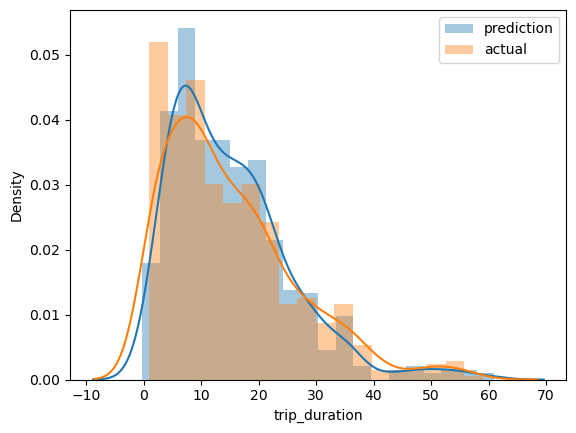

In [56]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y,label='actual')
plt.legend() 

In [57]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_pred,y,squared=False)
#mean_squared_error (MSE) is commonly used to evaluate regression models in machine learning. 
#It measures the average squared difference between the predicted and actual values.
#It sensitive to large errors and should be used when you want to penalize large deviations
#it is differentiable and can be used for gradient descent (only really applicable to NNs)

4.803126149405008

In [58]:
mean_squared_error(yval_pred,y_val,squared=False)

8.798963014718344

In [59]:
'''import os
os.environ["GIT_PYTHON_REFRESH"] = "quiet"
import git'''

'import os\nos.environ["GIT_PYTHON_REFRESH"] = "quiet"\nimport git'

In [66]:
from sklearn.linear_model import Lasso
#keep track of history with mlflow
with mlflow.start_run():
    mlflow.set_tag('developer','Ewezu')
    #used to log runs
    #tagging runs to the name of the developer helps to find runs of members in the team
    mlflow.log_param("train-data-path","C:\\Users\\FACULTY OFFICIAL\\Downloads\\green_tripdata_2021-01.parquet" )
    mlflow.log_param("val-data-path","C:\\Users\\FACULTY OFFICIAL\\Downloads\\green_tripdata_2021-02.parquet")
    #to log hyperparameters but also any other information deemed relevant
    alpha=0.1
    mlflow.log_param('alpha',alpha)
    Regressor=Lasso(alpha)
    Regressor.fit(X_train, y)
    #y_pred=Regressor.predict(X_train)
    yval_pred=Regressor.predict(XVal_train)
    mse=mean_squared_error(yval_pred,y_val,squared=False)
    mlflow.log_metric("mse",mse)
    mlflow.log_artifact(local_path="C:\\Users\\FACULTY OFFICIAL\\linear_reg.bin", artifact_path="models_pickle")
    #saving the model to mlflow

In [67]:
import xgboost as xgb
#!pip install hyperopt

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
#fmin is used to minimize the ouput of your model
#tpe is the algorithm used to optimize the process?
#hp defines the search space
#status ok tells hyperopt process has run sucessfully
#trials keeps track of info for each run
from hyperopt.pyll import scope
#scope defines range of integer

In [68]:
train=xgb.DMatrix(X_train,label=y)
valid=xgb.DMatrix(XVal_train,y_val)

In [69]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model","xgboost")
        mlflow.log_params(params)
        booster=xgb.train(
        params=params,
        dtrain=train,
        num_boost_round=1000,
        evals=[(valid,"validation")],
        early_stopping_rounds=50)
        y_pred=booster.predict(valid)
        mse=mean_squared_error(yval_pred,y_val,squared=False)
        mlflow.log_metric("mse", mse)
    
    return {'loss':mse, 'status':STATUS_OK}

In [70]:
#search space means the range you want hyperopt to explore
search_space= {
    'max_depth':scope.int(hp.quniform('max depth',4,100,1)),
    'learning_rate': hp.loguniform('learning_rate', -3,0),
    'reg_alpha':hp.loguniform('reg_alpha',-5,-1),
    'reg_lambda':hp.loguniform('reg_lambda',-6,-1),
    'min_child_weight': hp.loguniform('min_child_weight',-1,3),
    'objective':'reg:linear',
    'seed':42
}

best_result=fmin(fn=objective, 
                 space=search_space,
                 algo=tpe.suggest, 
                 max_evals=50,
                trials=Trials( ))

[0]	validation-rmse:11.02650                                                                                           
[1]	validation-rmse:10.57229                                                                                           
[2]	validation-rmse:10.18059                                                                                           
[3]	validation-rmse:9.83677                                                                                            
[4]	validation-rmse:9.54102                                                                                            
[5]	validation-rmse:9.28185                                                                                            
[6]	validation-rmse:9.06492                                                                                            
[7]	validation-rmse:8.86853                                                                                            
[8]	validation-rmse:8.69797             

C:\Users\FACULTY OFFICIAL\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:44:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[16]	validation-rmse:8.01531                                                                                           
[17]	validation-rmse:7.98295                                                                                           
[18]	validation-rmse:7.93989                                                                                           
[19]	validation-rmse:7.91609                                                                                           
[20]	validation-rmse:7.89598                                                                                           
[21]	validation-rmse:7.88158                                                                                           
[22]	validation-rmse:7.86659                                                                                           
[23]	validation-rmse:7.85170                                                                                           
[24]	validation-rmse:7.84550            

C:\Users\FACULTY OFFICIAL\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:44:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[25]	validation-rmse:8.32625
[26]	validation-rmse:8.33610                                                                                           
[27]	validation-rmse:8.34701                                                                                           
[28]	validation-rmse:8.38125                                                                                           
[29]	validation-rmse:8.39146                                                                                           
[30]	validation-rmse:8.40074                                                                                           
[31]	validation-rmse:8.42407                                                                                           
[32]	validation-rmse:8.38159                                                                                           
[33]	validation-rmse:8.40272                                                                                           
[34]	valida

C:\Users\FACULTY OFFICIAL\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:44:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[45]	validation-rmse:7.59086                                                                                           
[46]	validation-rmse:7.59563                                                                                           
[47]	validation-rmse:7.59733                                                                                           
[48]	validation-rmse:7.60341                                                                                           
[49]	validation-rmse:7.59450                                                                                           
[50]	validation-rmse:7.58485                                                                                           
[51]	validation-rmse:7.57299                                                                                           
[52]	validation-rmse:7.56128                                                                                           
[53]	validation-rmse:7.57072            

C:\Users\FACULTY OFFICIAL\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:44:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[24]	validation-rmse:8.19252
[25]	validation-rmse:8.19926                                                                                           
[26]	validation-rmse:8.20716                                                                                           
[27]	validation-rmse:8.22725                                                                                           
[28]	validation-rmse:8.25241                                                                                           
[29]	validation-rmse:8.29538                                                                                           
[30]	validation-rmse:8.28537                                                                                           
[31]	validation-rmse:8.30115                                                                                           
[32]	validation-rmse:8.29080                                                                                           
[33]	valida

C:\Users\FACULTY OFFICIAL\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:44:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[35]	validation-rmse:7.74092                                                                                           
[36]	validation-rmse:7.74196                                                                                           
[37]	validation-rmse:7.74189                                                                                           
[38]	validation-rmse:7.76143                                                                                           
[39]	validation-rmse:7.76317                                                                                           
[40]	validation-rmse:7.76265                                                                                           
[41]	validation-rmse:7.78363                                                                                           
[42]	validation-rmse:7.77630                                                                                           
[43]	validation-rmse:7.77451            

C:\Users\FACULTY OFFICIAL\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:44:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[27]	validation-rmse:7.88714                                                                                           
[28]	validation-rmse:7.89284                                                                                           
[29]	validation-rmse:7.89737                                                                                           
[30]	validation-rmse:7.92120                                                                                           
[31]	validation-rmse:7.94032                                                                                           
[32]	validation-rmse:7.95679                                                                                           
[33]	validation-rmse:7.97717                                                                                           
[34]	validation-rmse:7.98729                                                                                           
[35]	validation-rmse:8.01743            

C:\Users\FACULTY OFFICIAL\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:44:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[31]	validation-rmse:7.67733                                                                                           
[32]	validation-rmse:7.65872                                                                                           
[33]	validation-rmse:7.63788                                                                                           
[34]	validation-rmse:7.63025                                                                                           
[35]	validation-rmse:7.62605                                                                                           
[36]	validation-rmse:7.61841                                                                                           
[37]	validation-rmse:7.60787                                                                                           
[38]	validation-rmse:7.59676                                                                                           
[39]	validation-rmse:7.58598            

C:\Users\FACULTY OFFICIAL\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:44:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[21]	validation-rmse:8.34534                                                                                           
[22]	validation-rmse:8.35699                                                                                           
[23]	validation-rmse:8.35976                                                                                           
[24]	validation-rmse:8.36380                                                                                           
[25]	validation-rmse:8.38396                                                                                           
[26]	validation-rmse:8.38568                                                                                           
[27]	validation-rmse:8.39181                                                                                           
[28]	validation-rmse:8.39430                                                                                           
[29]	validation-rmse:8.40536            

C:\Users\FACULTY OFFICIAL\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:44:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[18]	validation-rmse:7.95604                                                                                           
[19]	validation-rmse:7.93306                                                                                           
[20]	validation-rmse:7.92027                                                                                           
[21]	validation-rmse:7.90506                                                                                           
[22]	validation-rmse:7.89100                                                                                           
[23]	validation-rmse:7.89611                                                                                           
[24]	validation-rmse:7.89254                                                                                           
[25]	validation-rmse:7.89156                                                                                           
[26]	validation-rmse:7.89302            

C:\Users\FACULTY OFFICIAL\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:44:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[23]	validation-rmse:7.90016
[24]	validation-rmse:7.91324                                                                                           
[25]	validation-rmse:7.91668                                                                                           
[26]	validation-rmse:7.92432                                                                                           
[27]	validation-rmse:7.93743                                                                                           
[28]	validation-rmse:7.92758                                                                                           
[29]	validation-rmse:7.92163                                                                                           
[30]	validation-rmse:7.92131                                                                                           
[31]	validation-rmse:7.92052                                                                                           
[32]	valida

C:\Users\FACULTY OFFICIAL\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:44:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[25]	validation-rmse:7.63655
[26]	validation-rmse:7.64529                                                                                           
[27]	validation-rmse:7.63773                                                                                           
[28]	validation-rmse:7.61793                                                                                           
[29]	validation-rmse:7.62116                                                                                           
[30]	validation-rmse:7.60847                                                                                           
[31]	validation-rmse:7.61390                                                                                           
[32]	validation-rmse:7.60408                                                                                           
[33]	validation-rmse:7.60107                                                                                           
[34]	valida

C:\Users\FACULTY OFFICIAL\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:44:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[10]	validation-rmse:8.94574                                                                                           
[11]	validation-rmse:8.96601                                                                                           
[12]	validation-rmse:8.96788                                                                                           
[13]	validation-rmse:8.97447                                                                                           
[14]	validation-rmse:8.99601                                                                                           
[15]	validation-rmse:9.02018                                                                                           
[16]	validation-rmse:9.02213                                                                                           
[17]	validation-rmse:9.03687                                                                                           
[18]	validation-rmse:9.06095            

C:\Users\FACULTY OFFICIAL\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:44:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[14]	validation-rmse:8.00383                                                                                           
[15]	validation-rmse:8.05962                                                                                           
[16]	validation-rmse:8.08839                                                                                           
[17]	validation-rmse:8.11526                                                                                           
[18]	validation-rmse:8.14996                                                                                           
[19]	validation-rmse:8.19777                                                                                           
[20]	validation-rmse:8.18961                                                                                           
[21]	validation-rmse:8.17611                                                                                           
[22]	validation-rmse:8.21168            

C:\Users\FACULTY OFFICIAL\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:44:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[25]	validation-rmse:7.66340                                                                                           
[26]	validation-rmse:7.65833                                                                                           
[27]	validation-rmse:7.67053                                                                                           
[28]	validation-rmse:7.68434                                                                                           
[29]	validation-rmse:7.67715                                                                                           
[30]	validation-rmse:7.68894                                                                                           
[31]	validation-rmse:7.69220                                                                                           
[32]	validation-rmse:7.70468                                                                                           
[33]	validation-rmse:7.71779            

C:\Users\FACULTY OFFICIAL\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:44:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[18]	validation-rmse:8.05384                                                                                           
[19]	validation-rmse:8.05612                                                                                           
[20]	validation-rmse:8.05731                                                                                           
[21]	validation-rmse:8.07498                                                                                           
[22]	validation-rmse:8.06850                                                                                           
[23]	validation-rmse:8.08491                                                                                           
[24]	validation-rmse:8.09578                                                                                           
[25]	validation-rmse:8.11102                                                                                           
[26]	validation-rmse:8.12646            

C:\Users\FACULTY OFFICIAL\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:44:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[36]	validation-rmse:7.59391                                                                                           
[37]	validation-rmse:7.59379                                                                                           
[38]	validation-rmse:7.58821                                                                                           
[39]	validation-rmse:7.58840                                                                                           
[40]	validation-rmse:7.59078                                                                                           
[41]	validation-rmse:7.58794                                                                                           
[42]	validation-rmse:7.58472                                                                                           
[43]	validation-rmse:7.58710                                                                                           
[44]	validation-rmse:7.58783            

C:\Users\FACULTY OFFICIAL\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:44:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[25]	validation-rmse:8.12544                                                                                           
[26]	validation-rmse:8.15317                                                                                           
[27]	validation-rmse:8.14949                                                                                           
[28]	validation-rmse:8.15883                                                                                           
[29]	validation-rmse:8.14501                                                                                           
[30]	validation-rmse:8.16436                                                                                           
[31]	validation-rmse:8.16338                                                                                           
[32]	validation-rmse:8.17209                                                                                           
[33]	validation-rmse:8.15201            

C:\Users\FACULTY OFFICIAL\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:44:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[23]	validation-rmse:7.98167                                                                                           
[24]	validation-rmse:8.01606                                                                                           
[25]	validation-rmse:8.01757                                                                                           
[26]	validation-rmse:8.03219                                                                                           
[27]	validation-rmse:8.02820                                                                                           
[28]	validation-rmse:8.01410                                                                                           
[29]	validation-rmse:8.05551                                                                                           
[30]	validation-rmse:8.04275                                                                                           
[31]	validation-rmse:8.04144            

C:\Users\FACULTY OFFICIAL\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:44:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[27]	validation-rmse:8.01557                                                                                           
[28]	validation-rmse:7.99313                                                                                           
[29]	validation-rmse:7.96608                                                                                           
[30]	validation-rmse:7.94867                                                                                           
[31]	validation-rmse:7.92667                                                                                           
[32]	validation-rmse:7.91191                                                                                           
[33]	validation-rmse:7.89398                                                                                           
[34]	validation-rmse:7.88100                                                                                           
[35]	validation-rmse:7.86603            

C:\Users\FACULTY OFFICIAL\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:44:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[14]	validation-rmse:8.49282
[15]	validation-rmse:8.48383                                                                                           
[16]	validation-rmse:8.52568                                                                                           
[17]	validation-rmse:8.53222                                                                                           
[18]	validation-rmse:8.56847                                                                                           
[19]	validation-rmse:8.59337                                                                                           
[20]	validation-rmse:8.58356                                                                                           
[21]	validation-rmse:8.60231                                                                                           
[22]	validation-rmse:8.61598                                                                                           
[23]	valida

C:\Users\FACULTY OFFICIAL\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:44:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[6]	validation-rmse:8.16311                                                                                            
[7]	validation-rmse:8.19113                                                                                            
[8]	validation-rmse:8.21771                                                                                            
[9]	validation-rmse:8.23857                                                                                            
[10]	validation-rmse:8.25268                                                                                           
[11]	validation-rmse:8.26092                                                                                           
[12]	validation-rmse:8.26719                                                                                           
[13]	validation-rmse:8.27146                                                                                           
[14]	validation-rmse:8.27432            

C:\Users\FACULTY OFFICIAL\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:44:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[32]	validation-rmse:7.98534                                                                                           
[33]	validation-rmse:7.96935                                                                                           
[34]	validation-rmse:7.94802                                                                                           
[35]	validation-rmse:7.93562                                                                                           
[36]	validation-rmse:7.91719                                                                                           
[37]	validation-rmse:7.90778                                                                                           
[38]	validation-rmse:7.89679                                                                                           
[39]	validation-rmse:7.89020                                                                                           
[40]	validation-rmse:7.87702            

C:\Users\FACULTY OFFICIAL\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:44:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[10]	validation-rmse:7.95368                                                                                           
[11]	validation-rmse:7.98712                                                                                           
[12]	validation-rmse:8.02180                                                                                           
[13]	validation-rmse:8.05602                                                                                           
[14]	validation-rmse:8.09038                                                                                           
[15]	validation-rmse:8.12517                                                                                           
[16]	validation-rmse:8.15209                                                                                           
[17]	validation-rmse:8.17341                                                                                           
[18]	validation-rmse:8.19374            

C:\Users\FACULTY OFFICIAL\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:44:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[8]	validation-rmse:9.01799                                                                                            
[9]	validation-rmse:8.92845                                                                                            
[10]	validation-rmse:8.86508                                                                                           
[11]	validation-rmse:8.81904                                                                                           
[12]	validation-rmse:8.78550                                                                                           
[13]	validation-rmse:8.76438                                                                                           
[14]	validation-rmse:8.74776                                                                                           
[15]	validation-rmse:8.74249                                                                                           
[16]	validation-rmse:8.74540            

C:\Users\FACULTY OFFICIAL\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:44:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[30]	validation-rmse:8.01231
[31]	validation-rmse:7.98783                                                                                           
[32]	validation-rmse:7.96997                                                                                           
[33]	validation-rmse:7.95474                                                                                           
[34]	validation-rmse:7.94043                                                                                           
[35]	validation-rmse:7.92868                                                                                           
[36]	validation-rmse:7.90979                                                                                           
[37]	validation-rmse:7.90343                                                                                           
[38]	validation-rmse:7.89419                                                                                           
[39]	valida

C:\Users\FACULTY OFFICIAL\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:44:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[7]	validation-rmse:7.88771                                                                                            
[8]	validation-rmse:7.89926                                                                                            
[9]	validation-rmse:7.91835                                                                                            
[10]	validation-rmse:7.94712                                                                                           
[11]	validation-rmse:7.98710                                                                                           
[12]	validation-rmse:8.02462                                                                                           
[13]	validation-rmse:8.06242                                                                                           
[14]	validation-rmse:8.09864                                                                                           
[15]	validation-rmse:8.12923            

C:\Users\FACULTY OFFICIAL\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:44:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[14]	validation-rmse:8.37786                                                                                           
[15]	validation-rmse:8.35763                                                                                           
[16]	validation-rmse:8.33405                                                                                           
[17]	validation-rmse:8.32198                                                                                           
[18]	validation-rmse:8.31944                                                                                           
[19]	validation-rmse:8.31986                                                                                           
[20]	validation-rmse:8.31926                                                                                           
[21]	validation-rmse:8.31584                                                                                           
[22]	validation-rmse:8.31959            

C:\Users\FACULTY OFFICIAL\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:44:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[28]	validation-rmse:7.85634                                                                                           
[29]	validation-rmse:7.83839                                                                                           
[30]	validation-rmse:7.82910                                                                                           
[31]	validation-rmse:7.81318                                                                                           
[32]	validation-rmse:7.80718                                                                                           
[33]	validation-rmse:7.79510                                                                                           
[34]	validation-rmse:7.77951                                                                                           
[35]	validation-rmse:7.77215                                                                                           
[36]	validation-rmse:7.76110            

C:\Users\FACULTY OFFICIAL\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:44:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[10]	validation-rmse:8.15713                                                                                           
[11]	validation-rmse:8.20228                                                                                           
[12]	validation-rmse:8.24133                                                                                           
[13]	validation-rmse:8.27965                                                                                           
[14]	validation-rmse:8.31809                                                                                           
[15]	validation-rmse:8.35189                                                                                           
[16]	validation-rmse:8.37971                                                                                           
[17]	validation-rmse:8.40398                                                                                           
[18]	validation-rmse:8.42370            

C:\Users\FACULTY OFFICIAL\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:44:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[12]	validation-rmse:8.32664                                                                                           
[13]	validation-rmse:8.30655                                                                                           
[14]	validation-rmse:8.30147                                                                                           
[15]	validation-rmse:8.29388                                                                                           
[16]	validation-rmse:8.30356                                                                                           
[17]	validation-rmse:8.30515                                                                                           
[18]	validation-rmse:8.30296                                                                                           
[19]	validation-rmse:8.31364                                                                                           
[20]	validation-rmse:8.32059            

C:\Users\FACULTY OFFICIAL\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:44:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[22]	validation-rmse:7.94569                                                                                           
[23]	validation-rmse:7.92441                                                                                           
[24]	validation-rmse:7.90714                                                                                           
[25]	validation-rmse:7.89275                                                                                           
[26]	validation-rmse:7.87644                                                                                           
[27]	validation-rmse:7.86868                                                                                           
[28]	validation-rmse:7.85529                                                                                           
[29]	validation-rmse:7.84877                                                                                           
[30]	validation-rmse:7.84406            

C:\Users\FACULTY OFFICIAL\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:44:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[7]	validation-rmse:8.31408                                                                                            
[8]	validation-rmse:8.35459                                                                                            
[9]	validation-rmse:8.38314                                                                                            
[10]	validation-rmse:8.40388                                                                                           
[11]	validation-rmse:8.42186                                                                                           
[12]	validation-rmse:8.43978                                                                                           
[13]	validation-rmse:8.44575                                                                                           
[14]	validation-rmse:8.45320                                                                                           
[15]	validation-rmse:8.46088            

C:\Users\FACULTY OFFICIAL\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:44:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[14]	validation-rmse:7.99616                                                                                           
[15]	validation-rmse:7.95639                                                                                           
[16]	validation-rmse:7.92903                                                                                           
[17]	validation-rmse:7.92123                                                                                           
[18]	validation-rmse:7.91038                                                                                           
[19]	validation-rmse:7.90690                                                                                           
[20]	validation-rmse:7.91053                                                                                           
[21]	validation-rmse:7.91262                                                                                           
[22]	validation-rmse:7.91047            

C:\Users\FACULTY OFFICIAL\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:44:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[19]	validation-rmse:7.99911                                                                                           
[20]	validation-rmse:7.97462                                                                                           
[21]	validation-rmse:7.94690                                                                                           
[22]	validation-rmse:7.92075                                                                                           
[23]	validation-rmse:7.90571                                                                                           
[24]	validation-rmse:7.88418                                                                                           
[25]	validation-rmse:7.86557                                                                                           
[26]	validation-rmse:7.85555                                                                                           
[27]	validation-rmse:7.84769            

C:\Users\FACULTY OFFICIAL\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:44:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[29]	validation-rmse:8.45111                                                                                           
[30]	validation-rmse:8.44573                                                                                           
[31]	validation-rmse:8.45500                                                                                           
[32]	validation-rmse:8.45795                                                                                           
[33]	validation-rmse:8.45461                                                                                           
[34]	validation-rmse:8.45370                                                                                           
[35]	validation-rmse:8.46127                                                                                           
[36]	validation-rmse:8.46610                                                                                           
[37]	validation-rmse:8.46591            

C:\Users\FACULTY OFFICIAL\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:44:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[18]	validation-rmse:7.87656                                                                                           
[19]	validation-rmse:7.88179                                                                                           
[20]	validation-rmse:7.89564                                                                                           
[21]	validation-rmse:7.92204                                                                                           
[22]	validation-rmse:7.91231                                                                                           
[23]	validation-rmse:7.93140                                                                                           
[24]	validation-rmse:7.94278                                                                                           
[25]	validation-rmse:7.94472                                                                                           
[26]	validation-rmse:7.95979            

C:\Users\FACULTY OFFICIAL\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:44:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[14]	validation-rmse:8.04928                                                                                           
[15]	validation-rmse:8.06613                                                                                           
[16]	validation-rmse:8.06165                                                                                           
[17]	validation-rmse:8.03985                                                                                           
[18]	validation-rmse:8.04973                                                                                           
[19]	validation-rmse:8.06290                                                                                           
[20]	validation-rmse:8.09782                                                                                           
[21]	validation-rmse:8.11818                                                                                           
[22]	validation-rmse:8.12110            

C:\Users\FACULTY OFFICIAL\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:44:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[9]	validation-rmse:8.53655                                                                                            
[10]	validation-rmse:8.54653                                                                                           
[11]	validation-rmse:8.55833                                                                                           
[12]	validation-rmse:8.56286                                                                                           
[13]	validation-rmse:8.57132                                                                                           
[14]	validation-rmse:8.57415                                                                                           
[15]	validation-rmse:8.57684                                                                                           
[16]	validation-rmse:8.57771                                                                                           
[17]	validation-rmse:8.57848            

C:\Users\FACULTY OFFICIAL\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:44:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[21]	validation-rmse:7.82028                                                                                           
[22]	validation-rmse:7.80878                                                                                           
[23]	validation-rmse:7.78948                                                                                           
[24]	validation-rmse:7.77575                                                                                           
[25]	validation-rmse:7.76311                                                                                           
[26]	validation-rmse:7.75348                                                                                           
[27]	validation-rmse:7.75634                                                                                           
[28]	validation-rmse:7.74879                                                                                           
[29]	validation-rmse:7.75959            

C:\Users\FACULTY OFFICIAL\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:44:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[21]	validation-rmse:8.23623                                                                                           
[22]	validation-rmse:8.18697                                                                                           
[23]	validation-rmse:8.14054                                                                                           
[24]	validation-rmse:8.10572                                                                                           
[25]	validation-rmse:8.06705                                                                                           
[26]	validation-rmse:8.03560                                                                                           
[27]	validation-rmse:8.00133                                                                                           
[28]	validation-rmse:7.97524                                                                                           
[29]	validation-rmse:7.94490            

C:\Users\FACULTY OFFICIAL\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:44:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[12]	validation-rmse:7.89114                                                                                           
[13]	validation-rmse:7.93070                                                                                           
[14]	validation-rmse:7.96071                                                                                           
[15]	validation-rmse:7.99144                                                                                           
[16]	validation-rmse:8.03065                                                                                           
[17]	validation-rmse:8.07776                                                                                           
[18]	validation-rmse:8.12222                                                                                           
[19]	validation-rmse:8.15288                                                                                           
[20]	validation-rmse:8.17395            

C:\Users\FACULTY OFFICIAL\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:44:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[16]	validation-rmse:7.80036                                                                                           
[17]	validation-rmse:7.80368                                                                                           
[18]	validation-rmse:7.81270                                                                                           
[19]	validation-rmse:7.82781                                                                                           
[20]	validation-rmse:7.83597                                                                                           
[21]	validation-rmse:7.85474                                                                                           
[22]	validation-rmse:7.85796                                                                                           
[23]	validation-rmse:7.85235                                                                                           
[24]	validation-rmse:7.86926            

C:\Users\FACULTY OFFICIAL\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:44:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[6]	validation-rmse:9.35187                                                                                            
[7]	validation-rmse:9.20273                                                                                            
[8]	validation-rmse:9.08464                                                                                            
[9]	validation-rmse:8.98961                                                                                            
[10]	validation-rmse:8.91463                                                                                           
[11]	validation-rmse:8.85206                                                                                           
[12]	validation-rmse:8.80498                                                                                           
[13]	validation-rmse:8.77084                                                                                           
[14]	validation-rmse:8.74762            

C:\Users\FACULTY OFFICIAL\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:44:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[18]	validation-rmse:7.91589                                                                                           
[19]	validation-rmse:7.89341                                                                                           
[20]	validation-rmse:7.87454                                                                                           
[21]	validation-rmse:7.83777                                                                                           
[22]	validation-rmse:7.82027                                                                                           
[23]	validation-rmse:7.80541                                                                                           
[24]	validation-rmse:7.77535                                                                                           
[25]	validation-rmse:7.75444                                                                                           
[26]	validation-rmse:7.74704            

C:\Users\FACULTY OFFICIAL\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:44:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[22]	validation-rmse:7.77148                                                                                           
[23]	validation-rmse:7.74512                                                                                           
[24]	validation-rmse:7.71430                                                                                           
[25]	validation-rmse:7.68557                                                                                           
[26]	validation-rmse:7.65271                                                                                           
[27]	validation-rmse:7.62503                                                                                           
[28]	validation-rmse:7.60644                                                                                           
[29]	validation-rmse:7.59914                                                                                           
[30]	validation-rmse:7.59433            

C:\Users\FACULTY OFFICIAL\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:44:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[22]	validation-rmse:7.66279                                                                                           
[23]	validation-rmse:7.65474                                                                                           
[24]	validation-rmse:7.65582                                                                                           
[25]	validation-rmse:7.65170                                                                                           
[26]	validation-rmse:7.65068                                                                                           
[27]	validation-rmse:7.64625                                                                                           
[28]	validation-rmse:7.65437                                                                                           
[29]	validation-rmse:7.65796                                                                                           
[30]	validation-rmse:7.65790            

C:\Users\FACULTY OFFICIAL\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:44:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[13]	validation-rmse:7.81958                                                                                           
[14]	validation-rmse:7.80935                                                                                           
[15]	validation-rmse:7.81170                                                                                           
[16]	validation-rmse:7.80153                                                                                           
[17]	validation-rmse:7.80562                                                                                           
[18]	validation-rmse:7.80718                                                                                           
[19]	validation-rmse:7.80186                                                                                           
[20]	validation-rmse:7.81344                                                                                           
[21]	validation-rmse:7.83475            

C:\Users\FACULTY OFFICIAL\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:44:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[14]	validation-rmse:8.29954                                                                                           
[15]	validation-rmse:8.29135                                                                                           
[16]	validation-rmse:8.33044                                                                                           
[17]	validation-rmse:8.33472                                                                                           
[18]	validation-rmse:8.33853                                                                                           
[19]	validation-rmse:8.36295                                                                                           
[20]	validation-rmse:8.36493                                                                                           
[21]	validation-rmse:8.38207                                                                                           
[22]	validation-rmse:8.39927            

C:\Users\FACULTY OFFICIAL\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:44:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[11]	validation-rmse:8.46458                                                                                           
[12]	validation-rmse:8.37062                                                                                           
[13]	validation-rmse:8.27709                                                                                           
[14]	validation-rmse:8.20394                                                                                           
[15]	validation-rmse:8.13662                                                                                           
[16]	validation-rmse:8.08257                                                                                           
[17]	validation-rmse:8.03619                                                                                           
[18]	validation-rmse:7.99672                                                                                           
[19]	validation-rmse:7.96896            

C:\Users\FACULTY OFFICIAL\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:44:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[8]	validation-rmse:8.46626                                                                                            
[9]	validation-rmse:8.47529                                                                                            
[10]	validation-rmse:8.47664                                                                                           
[11]	validation-rmse:8.48446                                                                                           
[12]	validation-rmse:8.49081                                                                                           
[13]	validation-rmse:8.49055                                                                                           
[14]	validation-rmse:8.49575                                                                                           
[15]	validation-rmse:8.50670                                                                                           
[16]	validation-rmse:8.51309            

In [72]:
#mlflow.autolog()
#can be used just before training
with mlflow.start_run():
     best_params={'learning_rate':0.0795197755405223,
          'max_depth':21,
          'min_child_weight':1.2331399947612292,
          'objective':'reg:linear',
          'reg_alpha':0.0447125218568576,
          'reg_lambda':0.047084099772748716,
          'seed': 42
     }
     mlflow.log_params(best_params)
     booster=xgb.train(
        params=best_params,
        dtrain=train,
        num_boost_round=1000,
        evals=[(valid,"validation")],
        early_stopping_rounds=50)
        
        
     y_pred=booster.predict(valid)
     mse=mean_squared_error(yval_pred,y_val,squared=False)
     mlflow.log_metric("mse", mse)
     with open('preprocessor.b','wb') as f_out:
            pickle.dump(dv,f_out)
     mlflow.log_artifact('preprocessor.b',artifact_path='preprocessor')
     mlflow.xgboost.log_model(booster,artifact_path="models_airflow")
      

[0]	validation-rmse:11.01338
[1]	validation-rmse:10.56175
[2]	validation-rmse:10.16678
[3]	validation-rmse:9.80885
[4]	validation-rmse:9.50153
[5]	validation-rmse:9.23921
[6]	validation-rmse:9.02248
[7]	validation-rmse:8.83465
[8]	validation-rmse:8.66622
[9]	validation-rmse:8.53568
[10]	validation-rmse:8.40880
[11]	validation-rmse:8.29262
[12]	validation-rmse:8.19470
[13]	validation-rmse:8.11618
[14]	validation-rmse:8.03851
[15]	validation-rmse:7.99614
[16]	validation-rmse:7.95619
[17]	validation-rmse:7.92299
[18]	validation-rmse:7.88963
[19]	validation-rmse:7.88322


C:\Users\FACULTY OFFICIAL\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:41:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[20]	validation-rmse:7.87121
[21]	validation-rmse:7.85601
[22]	validation-rmse:7.84600
[23]	validation-rmse:7.84964
[24]	validation-rmse:7.83153
[25]	validation-rmse:7.83252
[26]	validation-rmse:7.83002
[27]	validation-rmse:7.82727
[28]	validation-rmse:7.81763
[29]	validation-rmse:7.82108
[30]	validation-rmse:7.82684
[31]	validation-rmse:7.82648
[32]	validation-rmse:7.83706
[33]	validation-rmse:7.84131
[34]	validation-rmse:7.84962
[35]	validation-rmse:7.85199
[36]	validation-rmse:7.86542
[37]	validation-rmse:7.87716
[38]	validation-rmse:7.88773
[39]	validation-rmse:7.89592
[40]	validation-rmse:7.90693
[41]	validation-rmse:7.91958
[42]	validation-rmse:7.93616
[43]	validation-rmse:7.95523
[44]	validation-rmse:7.96897
[45]	validation-rmse:7.98325
[46]	validation-rmse:7.99139
[47]	validation-rmse:8.00429
[48]	validation-rmse:8.01258
[49]	validation-rmse:8.02377
[50]	validation-rmse:8.03788
[51]	validation-rmse:8.04978
[52]	validation-rmse:8.04045
[53]	validation-rmse:8.05424
[54]	validatio

C:\Users\FACULTY OFFICIAL\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:41:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


# Making Predictions with the mlflow model

In [74]:
logged_model = 'runs:/dcff92108ccb4e0b8c0e580ee11ecd08/models_airflow'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

#the model can be loaded as an mlflow.pyfunc obj or xgboost obj

C:\Users\FACULTY OFFICIAL\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:20:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


In [76]:
xgboost_model=mlflow.xgboost.load_model(logged_model)

C:\Users\FACULTY OFFICIAL\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:21:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


In [77]:
xgboost_model.predict(valid)

array([18.092428  ,  4.9105177 ,  4.154898  , 19.277182  , 17.136862  ,
        4.53814   , 25.53354   ,  7.5936866 ,  8.668748  , 14.484227  ,
       17.931099  ,  3.7279034 , 31.09014   , 13.140629  , 13.140629  ,
       27.24043   , 15.223828  ,  8.75468   , -1.8647541 ,  6.0387316 ,
       37.68742   ,  0.8488926 , 19.655418  , 16.25212   , 25.92107   ,
       21.205175  , 15.720515  ,  3.07422   , 17.777151  , 10.470493  ,
       13.454399  ,  8.693646  ,  2.9901643 , 24.70752   , 24.67025   ,
        8.414091  , 23.07355   , 20.67288   , 17.027733  , 31.09014   ,
       12.393068  ,  4.704141  , 10.787559  , 31.489046  ,  5.4813414 ,
       18.928053  , 44.135     ,  4.9105177 , 25.16155   , 13.608299  ,
       14.222352  , 22.379282  , 10.355038  , 27.129303  , 23.73428   ,
       18.576273  ,  1.9499454 , 17.624292  ,  4.8871455 , 21.131668  ,
       37.505733  ,  1.5501909 ,  5.6759415 , 31.868834  , 31.668297  ,
       11.384243  , 15.556151  ,  7.817701  , 11.2288065 , 26.83

In [ ]:
# Predict on a Pandas DataFrame.
loaded_model.predict(pd.DataFrame(data))